### **Chunk 7: Cross-Validation & Hyperparameter Tuning**

#### **1. Concept Introduction**

-   **Hyperparameters vs. Parameters**: Model **parameters** are learned from the data during `.fit()` (e.g., the coefficients in `LinearRegression`). Model **hyperparameters** are settings you choose *before* training (e.g., the number of trees in a `RandomForest`).

-   **The Problem with `train_test_split` for Tuning**: How do you pick the best hyperparameter? You could try several values, train each on `X_train`, and see which performs best on `X_test`. **This is a trap!** By using `X_test` to choose your hyperparameter, you have implicitly leaked information from the test set into your model selection process. Your final performance estimate will be overly optimistic. The test set must be kept in a vault, untouched until the very end.

-   **Cross-Validation (CV)**: The solution is to create a *validation set* out of the training set. The most robust way to do this is **K-Fold Cross-Validation**.
    1.  You split the *training data* into K equal-sized "folds" (e.g., K=5).
    2.  You train your model on K-1 folds and evaluate it on the held-out fold.
    3.  You repeat this K times, with each fold getting its turn as the validation set.
    4.  The final performance is the average of the K scores. This gives a much more stable and reliable estimate of your model's performance on unseen data.
    5.  **`StratifiedKFold`** is essential for classification. It ensures that the class distribution in each fold is the same as in the overall training set, which is critical for imbalanced datasets.

-   **Hyperparameter Tuning Tools**:
    1.  **`GridSearchCV`**: The brute-force method. You define a "grid" of hyperparameters you want to test (e.g., `n_estimators: [100, 200, 300]`, `max_depth: [5, 10, 15]`). It then uses cross-validation to exhaustively train and evaluate a model for *every single combination* of these parameters. It's thorough but can be very slow.
    2.  **`RandomizedSearchCV`**: A smarter, faster alternative. Instead of trying every combination, it samples a fixed number of random combinations from the grid. This is often more efficient because not all hyperparameters are equally important.
    3.  **Optuna (The Modern Standard)**: This is where we level up. Optuna is an advanced hyperparameter optimization framework that uses intelligent search strategies (like Bayesian optimization) to find the best parameters. Instead of searching blindly, it learns from past trials. If it sees that high values of a certain parameter are performing poorly, it will stop exploring that region and focus on more promising areas. This makes it vastly more efficient and effective than grid or random search. We will use Optuna as our primary tool.

#### **2. Dataset EDA: Credit Approval Dataset**

This dataset from the UCI repository concerns credit card applications. Due to confidentiality, all feature names have been anonymized (A1, A2, etc.). It's a great real-world example with mixed data types and a slightly imbalanced target, making it perfect for a tuned pipeline. The goal is to predict whether an application was approved (+) or rejected (-).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style('whitegrid')

**Load Data**

In [2]:
# The dataset has no header and uses `?` for missing values
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
col_names = [f'A{i}' for i in range(1, 16)] + ['class']
df = pd.read_csv(url, header = None, names=col_names,
                 na_values='?')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [3]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      678 non-null    object 
 1   A2      678 non-null    float64
 2   A3      690 non-null    float64
 3   A4      684 non-null    object 
 4   A5      684 non-null    object 
 5   A6      681 non-null    object 
 6   A7      681 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     677 non-null    float64
 14  A15     690 non-null    int64  
 15  class   690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB


**Data Cleaning and Type conversion**

In [4]:
# The class or 'y' label is object. Let's see it
print(df['class'].head(3))
print(f"Unique values in class : {np.unique(df['class'])}")
print("\nok great we can just convert this to 0 and 1")
df['class'] = (df['class'] == '+').astype(int) # Convert target to 0/1
print(df['class'].head(3))


0    +
1    +
2    +
Name: class, dtype: object
Unique values in class : ['+' '-']

ok great we can just convert this to 0 and 1
0    1
1    1
2    1
Name: class, dtype: int64


In [5]:
np.unique(df['class'])

array([0, 1])

**Missing Values check**

In [6]:
df.isnull().sum()

A1       12
A2       12
A3        0
A4        6
A5        6
A6        9
A7        9
A8        0
A9        0
A10       0
A11       0
A12       0
A13       0
A14      13
A15       0
class     0
dtype: int64

**Target Variable Distribution**

Target Variable Distribution
class
0    0.555072
1    0.444928
Name: proportion, dtype: float64


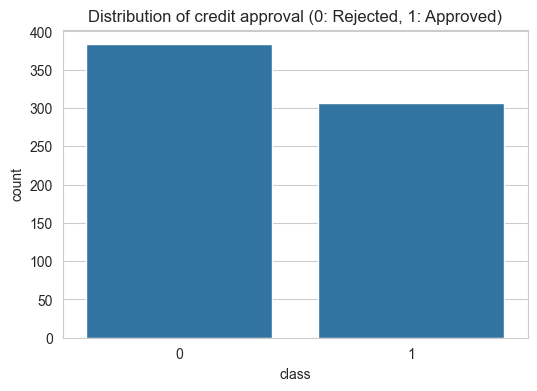

In [7]:
print("Target Variable Distribution")
print(df['class'].value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Distribution of credit approval (0: Rejected, 1: Approved)')
plt.show()


A very slight imbalance



##### **3. Minimal Working Example: From GridSearchCV to Optuna**

We'll use a RandomForestClassifier and tune its hyperparameters. First, we'll set up the pipeline just like in the last chunk.

In [11]:
# Setup, imports, Data, splitting, and Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df.drop(['class'], axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

numeric_features     = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric Features {numeric_features}")
print(f"Categorical Features {categorical_features}")
numeric_transformer = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Now we will define the model seperately to attach it to different search methods
model  = RandomForestClassifier(random_state=42,
                                n_jobs=-1)

Numeric Features ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
Categorical Features ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']


**Attempt : 1 : GridSearchCV (The Slow Way)**

In [12]:
from sklearn.model_selection import GridSearchCV

# Define the Pipeline
pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
    ])

# Define the parameter grid. Note the 'classifier__' prefic to target pipeline steps
param_grid = {
    'classifier__n_estimators':[50, 100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Total fits = 3 * 3 * 3 * 5(CV folds) = 135 models!!!

# Set up the search
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(pipeline,
                           param_grid=param_grid,
                           cv = cv,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# Run the search
print("Running Grid search cv")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Running Grid search cv
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters found: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.8749


#### **Attempt 2: Optuna (The professional Way)**

optuna requires you to define an "objective" function. This function takes a `trial` object, uses it to suggest hyperparameters, builds and evaluates the model, and returns the score you want to maximize or minimize

In [14]:
import optuna
from sklearn.model_selection import cross_val_score

# Define the optuna objective function
def objective(trial):
    # 1. define the hyperparmeter seach space
    # The pipeline and preprocessorare fixed, we only tune the classifier.
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest']) # We can even test differnt models.
    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth    = trial.suggest_int('max_depth', 3, 20)
        min_sample_leaf  = trial.suggest_int('min_samples_leaf', 1, 10)

        # Now we redefine the model inside the objhective with the suggested params
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_sample_leaf,
            random_state=42,
            n_jobs=-1
        )
    # Create the full pipeline
    pipeline = Pipeline(steps =[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Evaluate the pipeline using cross-validation
    # We use the same data and CV strategy as before for a fair comparison
    cv = StratifiedKFold(n_splits=5,
                         shuffle=True,
                         random_state=42)
    score= cross_val_score(
        pipeline,
        X_train,
        y_train,
        n_jobs=-1,
        cv= cv,
        scoring='accuracy'
    )
    accuracy = score.mean()
    
    return accuracy

In [15]:
# Run the Optuna study
# create_study directs Optuna to maximize the objective function's return value.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run for 50 trials (compare to 135 for GridSearch)

print("\n--- Optuna Results ---")
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial
print(f"  Value (accuracy): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-11-13 18:43:40,750] A new study created in memory with name: no-name-5d331fd8-eda0-4187-bd55-433abb26e614
[I 2025-11-13 18:43:46,890] Trial 0 finished with value: 0.8604750204750206 and parameters: {'classifier': 'RandomForest', 'n_estimators': 74, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8604750204750206.
[I 2025-11-13 18:43:51,932] Trial 1 finished with value: 0.8604750204750203 and parameters: {'classifier': 'RandomForest', 'n_estimators': 217, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8604750204750206.
[I 2025-11-13 18:43:52,628] Trial 2 finished with value: 0.8622932022932023 and parameters: {'classifier': 'RandomForest', 'n_estimators': 172, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8622932022932023.
[I 2025-11-13 18:43:53,537] Trial 3 finished with value: 0.8641277641277642 and parameters: {'classifier': 'RandomForest', 'n_estimators': 248, 'max_depth': 8, 'min_samples_leaf': 10}. Bes


--- Optuna Results ---
Number of finished trials: 50
Best trial:
  Value (accuracy): 0.8714
  Params: 
    classifier: RandomForest
    n_estimators: 287
    max_depth: 16
    min_samples_leaf: 8


#### **4. Using the Best Model**

Once you have the best hyperparameters from Optuna, you create the final model with them and train it on the entire training set. Then you do your final evaluation on the held-out test set.

In [17]:
study.best_params

{'classifier': 'RandomForest',
 'n_estimators': 287,
 'max_depth': 16,
 'min_samples_leaf': 8}

In [ ]:
# Get best params and create final pipeline
best_params = study.best_params
# The 'classifier' param is from our objective function, we don't need it for the model itself
best_params.pop('classifier') 

final_model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', final_model)])

# Train on the full training set
final_pipeline.fit(X_train, y_train)

# Evaluate on the unseen test set
test_accuracy = final_pipeline.score(X_test, y_test)
print(f"\nFinal Test Set Accuracy: {test_accuracy*100:.2f}%")


Final Test Set Accuracy: 89.86%
